# Donkey Car Default CNN (Control Experiment)

## Default CNN Setup against which all other models developed in this project will be compared to as a baseline

This Default CNN will be the 'minimum required functionality' design - just small enough to make predictions without overfitting to its own training data (when comparing validation and training loss)


The metrics that will be logged throughout all experiments will be training loss, validation loss, and prediction loss and accuracy. The parameters and factors logged will be the number of epochs, the layers, the batch size, the normalization and pruning used (if applicable) and the datasets used and their characteristics.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [3]:
#Mount Data Folder From Google Drive:

#path = "/content/drive/My Drive/DIYRobocars_2020/Data/halldatarecords2/"
path = "./Documents/DonkeyCar/SimDataGenTrack1/"
#path = "./Documents/DonkeyCar/SimDataWHCounterClockwise/"

In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataGenTrack1.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHClockwise.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHCounterClockwise.zip'

In [5]:
#Import required packages for this step:

import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

In [7]:
#Read data from files into corresponding lists
#You may need to run this cell several times - colabs connection to Drive times 
#out if the number of files to retrieve get too large. If this is the case, run
#it a few times until it works. Colab caches files already retrieved in the last run,
#so rerunning it several times will eventually get all the files read. Clumsy, but
#don't shoot the messenger. Their docs themselves say this.
%%time

im_list = [] #initialise list of images

rec_list = [] #initialise list of records

#Read relevant files into relevant lists

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

15061
15061
CPU times: user 12.9 ms, sys: 12.2 ms, total: 25.1 ms
Wall time: 26.4 ms


(15061, 120, 160, 3)
(15061,)
(15061,)
0.0
10.0


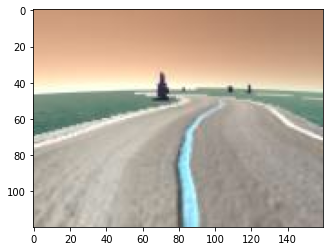

CPU times: user 13.9 s, sys: 4.05 s, total: 18 s
Wall time: 23.8 s


In [8]:
%%time

#Import Image from Pillow
from PIL import Image
#THIS TAKES ABSOLUTELY FOREVER TO RUN I AM SORRY - maybe try to copy paste zip file from drive to colab and work from there?
#Sort data lists and split into data and labels

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:

x_images = np.zeros((len(rec_list), width, height, color), dtype = np.float32)

print(x_images.shape)
#Read images into images array
for i in range(len(im_list)):
    filename = im_list[i]
    image = cv2.imread(path+filename)
    x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors

#read angle labels into y_angle array
json_data = {}
y_angle = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_angle.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_angle[i] = orient

#read throttle labels into y_throttle array
y_throttle = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_throttle.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        vroom = json_data['user/throttle']
        y_throttle[i] = vroom

randomImage = randrange(len(x_images)) #Get an index for a random image to show to ensure data read correctly
print(y_angle[randomImage])
print(y_throttle[randomImage])
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show() #Show Image

0.19998672066927828


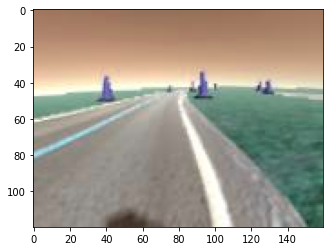

-0.7401903
10.0


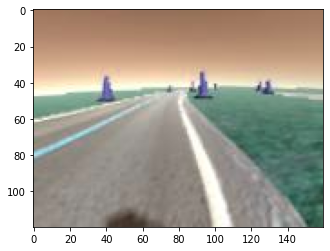

In [10]:
#Donkey Training and Val data splits

def train_test_split(data_list,label_list, label2_list, shuffle=True, test_size=0.2):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    label2_list = list(label2_list)
    train_data = []
    traina_labels =[]
    traint_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        traint_labels.append(label2_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    valt_labels = label_list
    return val_data, train_data, vala_labels, traina_labels, valt_labels, traint_labels

x_val, x_train, y_vala, y_traina, y_valt, y_traint = train_test_split(x_images,y_angle, y_throttle)

print(len(x_val)/len(x_images))

plt.imshow(x_train[1000].astype('uint8'))
plt.show()
print(y_traina[1000])
print(y_traint[1000])
x_val = np.asarray(x_val)/255 #Images best practices
y_vala = np.asarray(y_vala)
y_valt = np.asarray(y_valt)
x_train = np.asarray(x_train)/255
y_traina = np.asarray(y_traina)
y_traint = np.asarray(y_traint)


plt.imshow(x_train[1000])
plt.show()

### Step 2: Set Up Experiment and Train Donkey Model

In [11]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [19]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 100
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"

In [22]:
#Start Experiment:
neptune.create_experiment(name='Donkey Net Train',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Convolutional Layers': CONVLAYERS,
                                  'Dense Layers': DENSELAYERS,
                                  'Pooling Layers': POOLLAYERS,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS},         
                          tags=['Donkey_Train', 'Dual_Out'],
                          description="Default Training for Donkey Sim with a Donkey Model"
                          )


https://ui.neptune.ai/charag/Littlefoot/e/LIT-148


Experiment(LIT-148)

In [14]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [15]:
#Donkeycar Standard Regression Model
drop = 0.1
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)
x = Dropout(drop)(x)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4")(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)
x = Dropout(drop)(x)
    
x = Flatten(name='flattened')(x)
x = Dense(100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(drop)(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

In [16]:
#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 58, 78, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       dropout[0][0]                    
______________________________________________________________________________________________

In [23]:
#Fit Model to Data
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_n_outputs0_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint('Sim2.h5', monitor='val_n_outputs0_loss', verbose=1, save_best_only=True, mode='min')

#model.fit(x_fit, y_fit, epochs=EPOCH, batch_size=1, validation_data=(x_fit, y_fit),callbacks=[NeptuneLogger()], shuffle=True, verbose=1)

model.fit(x_train, [y_traina, y_traint], epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, [y_vala, y_valt]),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)

#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), save_best], shuffle=True, verbose=1)
#Stop Neptune Experiment:

neptune.stop()

Epoch 1/100
91/92 [============================>.] - ETA: 0s - loss: 0.9601 - n_outputs0_loss: 0.0842 - n_outputs1_loss: 0.8759 - n_outputs0_accuracy: 0.7738 - n_outputs1_accuracy: 0.3223
Epoch 00001: val_n_outputs0_loss improved from inf to 0.05954, saving model to Sim2.h5
92/92 [==============================] - 5s 58ms/step - loss: 0.9606 - n_outputs0_loss: 0.0842 - n_outputs1_loss: 0.8763 - n_outputs0_accuracy: 0.7738 - n_outputs1_accuracy: 0.3223 - val_loss: 44.5602 - val_n_outputs0_loss: 0.0595 - val_n_outputs1_loss: 44.5006 - val_n_outputs0_accuracy: 0.7912 - val_n_outputs1_accuracy: 0.1962
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 0.9322 - n_outputs0_loss: 0.0855 - n_outputs1_loss: 0.8467 - n_outputs0_accuracy: 0.7666 - n_outputs1_accuracy: 0.3218
Epoch 00002: val_n_outputs0_loss did not improve from 0.05954
92/92 [==============================] - 4s 45ms/step - loss: 0.9310 - n_outputs0_loss: 0.0853 - n_outputs1_loss: 0.8457 - n_outputs0_accuracy: 0

## STEP 3: Validate Your Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

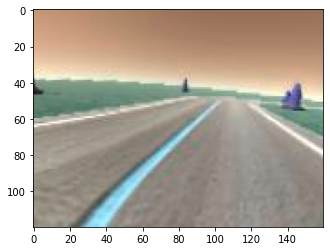

Label:
1.0


OSError: ignored

In [24]:
num = randrange(len(x_val))

#Select Random Image and Label to show as examples
plt.imshow(x_val[num])
plt.show()

pred_im = x_val[num]
pred_label = y_vala[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_vala))
perc = np.zeros(len(y_vala))

ModelBest = keras.models.load_model('Lit.h5')

#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_vala, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_val, [y_vala, y_valt], batch_size=BATCH, verbose=1)

for i in range(0, len(y_vala)):
  diff[i] = abs(y_vala[i] - label_out[i])
  perc[i] = (np.max(y_vala)-diff[i])/np.max(y_vala)
#model.save('LIT-16.h5')
print("result:")
print(label_out[num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))